-This notebook is to generate experimental plan for foundation model 

In [1]:
# Get the correspond data

In [18]:
pwd

'/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks'

In [19]:
import sys
sys.path.append("../src/models")
sys.path.append("../src")
sys.path.append("../")

In [20]:
import numpy as np
import pandas as pd
import pickle

from Extrapolability import get_sample_fromGP, get_sample_lack_feature, classifier_performance_update, get_sample_lack_features_mul
from utils import *

from xgboost import XGBClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF  
from sklearn.ensemble import RandomForestClassifier

In [21]:
# There is a mismatch between numpy version
# Now I'm using 'ActiveLearning' Environment

In [22]:
model_path = '/Users/haoliu/Documents/GitHub/MicroscopyAnalysis/GPC_model_20240713.pkl' # GP model
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/Info.csv' # 7 amphipihles in AL paper

# Data set with only old molecules
Feature = ['All_features_reserved']
df1, model_gp = get_sample_fromGP(model_path, info_path, Feature)

In [24]:
df1['vesicles_formation'].max()

1

In [5]:
# Original dataset, get the classifier model based on fm model
x_smi = get_latent_space(df1)
xtrain = x_smi
ytrain = df1['vesicles_formation']

def get_classifier(xtrain, ytrain):

    # Train Random Forest classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(xtrain, ytrain)

    return rf_clf
    
# Using random forest classifier
model_clf = get_classifier(xtrain, ytrain)

Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:00<00:00,  7.22it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


In [55]:
model_clf

RandomForestClassifier(random_state=42)

In [6]:
# Do prediction
x_smi_ori = get_latent_space(df1)
y_pred_ori = model_clf.predict_proba(x_smi_ori)[:,1]

Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


Explained variance ratio (first 2 components): [0.99371454 0.00286341]


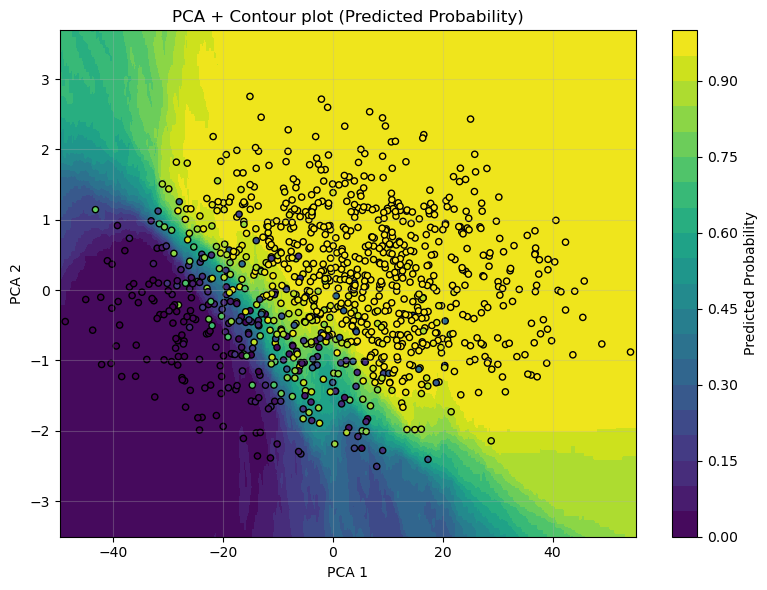

ValueError: too many values to unpack (expected 3)

In [7]:
pca0, grid_points0, Z_prob0 = pca_model_contour_plot(
    X=x_smi_ori,
    y_pred=y_pred_ori,
    model=model_clf
)

In [12]:
x_smi_ori.shape

(1000, 768)

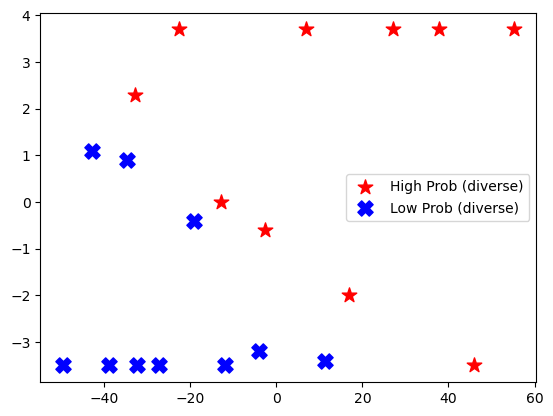

In [8]:
# This is ok to select points in latent space, but it's not reversible to original data 
# (since it's a combination of molecules and concentrations)

high_PCA, low_PCA, high_original, low_original = select_diverse_grid_points(
    pca0, grid_points0, Z_prob0, n_high=10, n_low=10
)

# Optionally plot selected points on top
plt.scatter(high_PCA[:, 0], high_PCA[:, 1], c='red', marker='*', s=120, label='High Prob (diverse)')
plt.scatter(low_PCA[:, 0], low_PCA[:, 1], c='blue', marker='X', s=120, label='Low Prob (diverse)')
plt.legend()

In [10]:
high_original

array([[ 2.3720972 , -3.68860144,  0.85482524, ...,  7.98299247,
         5.16710903, -0.49994268],
       [ 0.9867577 , -1.39888353,  0.36318201, ...,  2.72032414,
         1.89840645, -0.12293841],
       [ 1.78732408, -2.58318198,  0.66347792, ...,  5.05477768,
         3.50291711, -0.2401906 ],
       ...,
       [ 2.38523081, -3.49824385,  0.88419436, ...,  6.95379483,
         4.7638392 , -0.34990033],
       [ 1.21834831, -1.71239729,  0.45344131, ...,  3.24764847,
         2.30300738, -0.13578941],
       [ 1.50487726, -2.27660345,  0.54456867, ...,  4.79726782,
         3.16464984, -0.27941239]])

In [11]:
low_original.shape

(10, 768)

In [13]:
# Select based on actual data 

Explained variance ratio (first 2 components): [0.99371454 0.00286341]


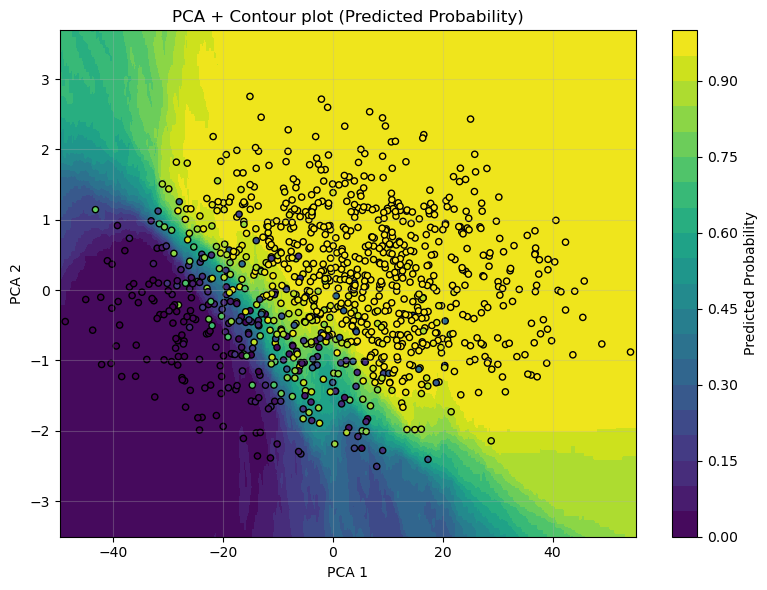

In [7]:
_, _, Z_prob0, X_reduced0 = pca_model_contour_plot(
    X=x_smi_ori,
    y_pred=y_pred_ori,
    model=model_clf
)

In [15]:
high_idxs, low_idxs = select_diverse_data_indices(X_reduced0, Z_prob0, n_select=10)
print(high_idxs, low_idxs)
high_samples0 = df1.iloc[high_idxs]
low_samples0 = df1.iloc[low_idxs]

[1, 408, 400, 250, 143, 162, 843, 131, 150, 614] [4, 628, 165, 100, 981, 800, 95, 310, 908, 472]


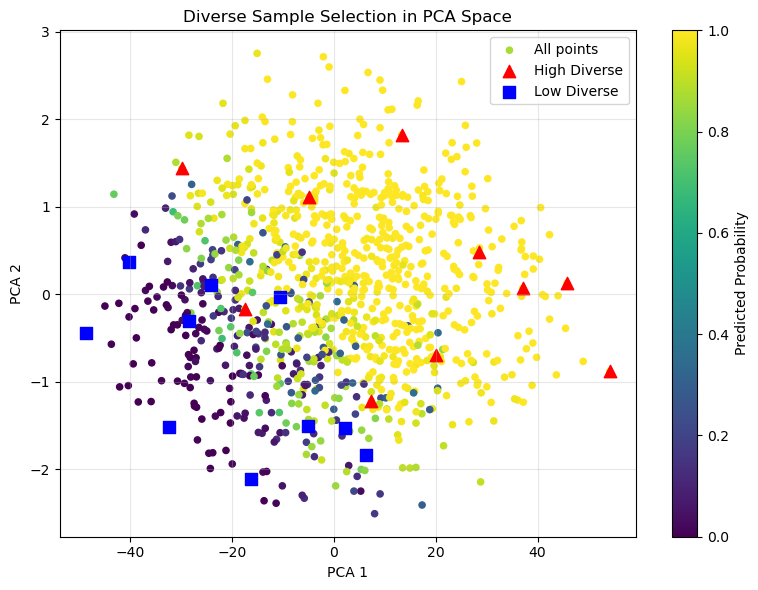

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(X_reduced0[:, 0], X_reduced0[:, 1], c=Z_prob0, cmap='viridis', s=20, label='All points')
plt.scatter(X_reduced0[high_idxs, 0], X_reduced0[high_idxs, 1], c='red', marker='^', s=80, label='High Diverse')
plt.scatter(X_reduced0[low_idxs, 0], X_reduced0[low_idxs, 1], c='blue', marker='s', s=80, label='Low Diverse')
plt.colorbar(label='Predicted Probability')
plt.legend()
plt.title("Diverse Sample Selection in PCA Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
# Integrate functions

Explained variance ratio (first 2 components): [0.99371454 0.00286341]


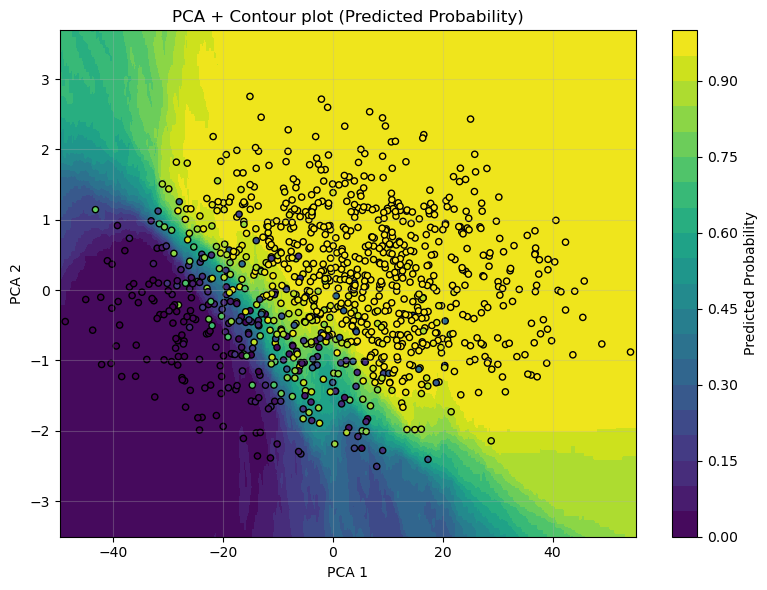

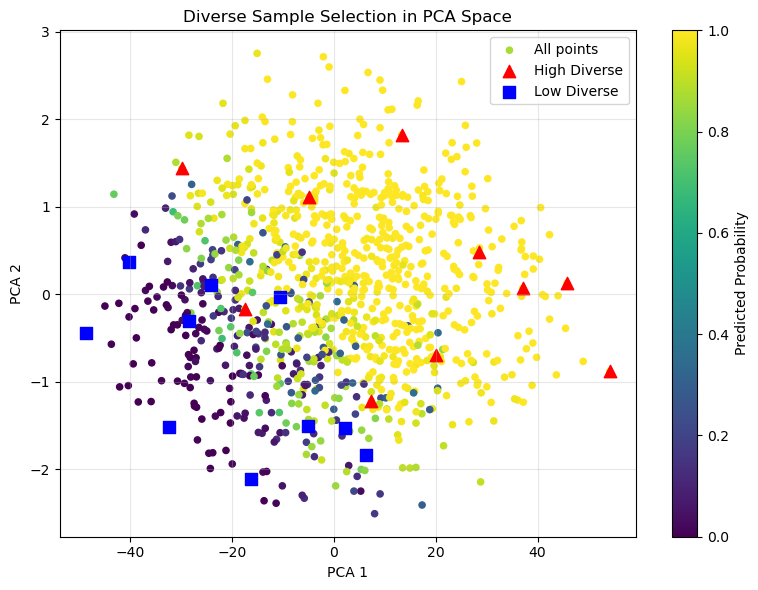

In [8]:
high_samples0, low_samples0, high_idxs0, low_idxs0 = run_diverse_selection_workflow(
    X=x_smi_ori,
    y_pred=y_pred_ori,
    model=model_clf,
    df_reference=df1,
    n_select=10
)

In [9]:
# Gather other dataset

In [9]:
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/info_new_molecules.csv'
df_info = pd.read_csv(info_path)
df_info['Name']

0                                              Decanal
1                                             Geraniol
2                                    Hexadecanoic acid
3                                     Myristoleic acid
4                                   Glycine octylester
5                               Perfluorooctanoic acid
6     1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid
7    Heptadecafluorooctanesulfonic acid potassium salt
Name: Name, dtype: object

In [ ]:
# only change one similar molecules
df_new1=df1.copy()
#  List the SMILES columns in df1 (every second column, starting from index 0)
smiles_columns = [col for col in df1.columns if 'smi' in col]

# Randomly pick 5 of these columns
selected_smiles_cols = ['smi4']

# Get 5 new SMILES from df_info
new_smiles = df_info['SMILES'].iloc[:5].tolist()

#  Replace the entire column in df1 with new SMILES
for col, new_smi in zip(selected_smiles_cols, new_smiles):
    df_new1[col] = new_smi

# now have a new version of df1 with 5 molecules replaced
print("Replaced columns:", selected_smiles_cols)
print("With new SMILES:", new_smiles)

x_smi_similar1 = get_latent_space(df_new1)
y_pred1 = model_clf.predict_proba(x_smi_similar1)[:,1]

Replaced columns: ['smi4']
With new SMILES: ['CCCCCCCCCC=O', 'CC(=CCC/C(=C/CO)/C)C', 'CCCCCCCCCCCCCCCC(=O)O', 'CCCC/C=C\\CCCCCCCC(=O)O', 'CCCCCCCCOC(=O)CN.Cl']
Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:01<00:00,  6.50it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


In [ ]:
# Replace 5 similar
df_new2=df1.copy()
# 1. List the SMILES columns in df1 (every second column, starting from index 0)
smiles_columns = [col for col in df1.columns if 'smi' in col]

# 2. Randomly pick 5 of these columns
selected_smiles_cols = ['smi6', 'smi1', 'smi5', 'smi4', 'smi3']

# 3. Get 5 new SMILES from df_info
new_smiles = df_info['SMILES'].iloc[:5].tolist()

# 4. Replace the entire column in df1 with new SMILES
for col, new_smi in zip(selected_smiles_cols, new_smiles):
    df_new2[col] = new_smi

# now have a new version of df1 with 5 molecules replaced
print("Replaced columns:", selected_smiles_cols)
print("With new SMILES:", new_smiles)

x_smi_similar2 = get_latent_space(df_new2)
y_pred2 = model_clf.predict_proba(x_smi_similar2)[:,1]

Replaced columns: ['smi6', 'smi1', 'smi5', 'smi4', 'smi3']
With new SMILES: ['CCCCCCCCCC=O', 'CC(=CCC/C(=C/CO)/C)C', 'CCCCCCCCCCCCCCCC(=O)O', 'CCCC/C=C\\CCCCCCCC(=O)O', 'CCCCCCCCOC(=O)CN.Cl']
Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:00<00:00,  7.87it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


In [40]:
columns_to_check = [f'smi{i}' for i in range(1, 8)]
replacement_mapping = {}

# Go through each column in df_new2 and compare values to df_info['SMILES']
for col in columns_to_check:
    col_values = df_new2[col].unique()
    for smile in col_values:
        match = df_info[df_info['SMILES'] == smile]
        if not match.empty:
            replacement_mapping[col] = match.iloc[0]['Name']
            break  # We assume one unique match per column

# Display the mapping
for col, mol_name in replacement_mapping.items():
    print(f"{col} was replaced by {mol_name}")

smi1 was replaced by Geraniol
smi3 was replaced by Glycine octylester
smi4 was replaced by Myristoleic acid
smi5 was replaced by Hexadecanoic acid
smi6 was replaced by Decanal


In [44]:
high_samples2.head()

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
7,CC(=CCC/C(=C/CO)/C)C,0.331215,CCCCCCCCCC(=O)[O-],1.737262,CCCCCCCCOC(=O)CN.Cl,1.388852,CCCC/C=C\CCCCCCCC(=O)O,1.683356,CCCCCCCCCCCCCCCC(=O)O,1.603315,CCCCCCCCCC=O,0.547850,CCCCCCCCCC(=O)OCC(CO)O,0.638995,1
845,CC(=CCC/C(=C/CO)/C)C,0.150889,CCCCCCCCCC(=O)[O-],1.764123,CCCCCCCCOC(=O)CN.Cl,1.194042,CCCC/C=C\CCCCCCCC(=O)O,0.511375,CCCCCCCCCCCCCCCC(=O)O,1.049628,CCCCCCCCCC=O,0.100318,CCCCCCCCCC(=O)OCC(CO)O,0.669467,1
71,CC(=CCC/C(=C/CO)/C)C,0.139282,CCCCCCCCCC(=O)[O-],1.745881,CCCCCCCCOC(=O)CN.Cl,1.767052,CCCC/C=C\CCCCCCCC(=O)O,1.250938,CCCCCCCCCCCCCCCC(=O)O,0.960556,CCCCCCCCCC=O,0.283617,CCCCCCCCCC(=O)OCC(CO)O,0.564080,1
400,CC(=CCC/C(=C/CO)/C)C,1.420140,CCCCCCCCCC(=O)[O-],1.626736,CCCCCCCCOC(=O)CN.Cl,1.690886,CCCC/C=C\CCCCCCCC(=O)O,1.720332,CCCCCCCCCCCCCCCC(=O)O,0.934330,CCCCCCCCCC=O,0.895498,CCCCCCCCCC(=O)OCC(CO)O,0.524927,1
963,CC(=CCC/C(=C/CO)/C)C,0.202905,CCCCCCCCCC(=O)[O-],1.021638,CCCCCCCCOC(=O)CN.Cl,1.544217,CCCC/C=C\CCCCCCCC(=O)O,0.854866,CCCCCCCCCCCCCCCC(=O)O,1.782020,CCCCCCCCCC=O,0.622319,CCCCCCCCCC(=O)OCC(CO)O,0.051345,1


In [ ]:
['Decanoic acid',
'Decanoate',
'Decylamine',
'Decyltrimethyl ammonium bromid',
'Decyl sodium sulfate',
'Decanol',
'Glycerol monodecanoate']

In [41]:
df_info

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,ID,Name,Molecular_Formula,InChI,SMILES
0,A1,Decanal,C10H20O,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-9-10-11/h10H...,CCCCCCCCCC=O
1,A2,Geraniol,C10H18O,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",CC(=CCC/C(=C/CO)/C)C
2,A3,Hexadecanoic acid,C16H32O2,InChI=1S/C16H32O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCCCCCCCCCCCCCC(=O)O
3,A4,Myristoleic acid,C14H26O2,InChI=1S/C14H26O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCC/C=C\CCCCCCCC(=O)O
4,A5,Glycine octylester,C10H22ClNO2,InChI=1S/C10H21NO2.ClH/c1-2-3-4-5-6-7-8-13-10(...,CCCCCCCCOC(=O)CN.Cl
5,A6,Perfluorooctanoic acid,C8HF15O2,"InChI=1S/C8HF15O2/c9-2(10,1(24)25)3(11,12)4(13...",C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F...
6,A7,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",C8H5F13O3S,"InChI=1S/C8H5F13O3S/c9-3(10,1-2-25(22,23)24)4(...",C(CS(=O)(=O)O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)...
7,A8,Heptadecafluorooctanesulfonic acid potassium salt,C8F17KO3S,"InChI=1S/C8HF17O3S.K/c9-1(10,3(13,14)5(17,18)7...",C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...


In [ ]:
# 1 dissimilar
df_new3=df1.copy()
# 1. List the SMILES columns in df1 (every second column, starting from index 0)
smiles_columns = [col for col in df1.columns if 'smi' in col]

# 2. Randomly pick 5 of these columns
selected_smiles_cols = ['smi6']

# 3. Get 5 new SMILES from df_info
new_smiles2 = df_info['SMILES'].iloc[5:].tolist()

# 4. Replace the entire column in df1 with new SMILES
for col, new_smi in zip(selected_smiles_cols, new_smiles2):
    df_new3[col] = new_smi

# now have a new version of df1 with 5 molecules replaced
print("Replaced columns:", selected_smiles_cols)
print("With new SMILES:", new_smiles2)

x_smi_similar3 = get_latent_space(df_new3)
y_pred3 = model_clf.predict_proba(x_smi_similar3)[:,1]

Replaced columns: ['smi6']
With new SMILES: ['C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O', 'C(CS(=O)(=O)O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F', 'C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C(C(C(F)(F)F)(F)F)(F)F)(F)F.[K+]']
Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:01<00:00,  5.06it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


In [13]:
# 3 dissimilar
df_new4=df1.copy()
# 1. List the SMILES columns in df1 (every second column, starting from index 0)
smiles_columns = [col for col in df1.columns if 'smi' in col]

# 2. Randomly pick 5 of these columns
selected_smiles_cols = ['smi4', 'smi6', 'smi1']

# 3. Get 5 new SMILES from df_info
new_smiles2 = df_info['SMILES'].iloc[5:].tolist()

# 4. Replace the entire column in df1 with new SMILES
for col, new_smi in zip(selected_smiles_cols, new_smiles2):
    df_new4[col] = new_smi

# Done! You now have a new version of df1 with 5 molecules replaced
print("Replaced columns:", selected_smiles_cols)
print("With new SMILES:", new_smiles2)

x_smi_similar4 = get_latent_space(df_new4)
y_pred4 = model_clf.predict_proba(x_smi_similar4)[:,1]

Replaced columns: ['smi4', 'smi6', 'smi1']
With new SMILES: ['C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)O', 'C(CS(=O)(=O)O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F', 'C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C(C(C(F)(F)F)(F)F)(F)F)(F)F.[K+]']
Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:01<00:00,  5.62it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


Explained variance ratio (first 2 components): [0.99495046 0.00304232]


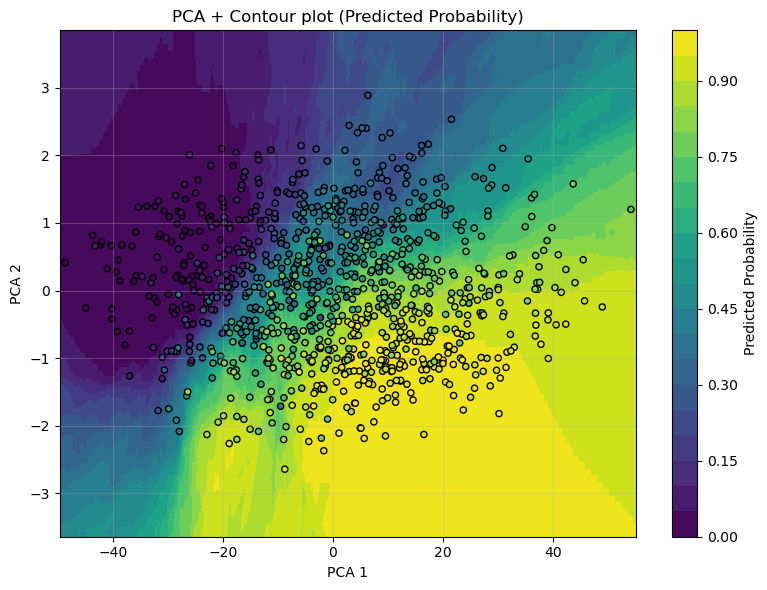

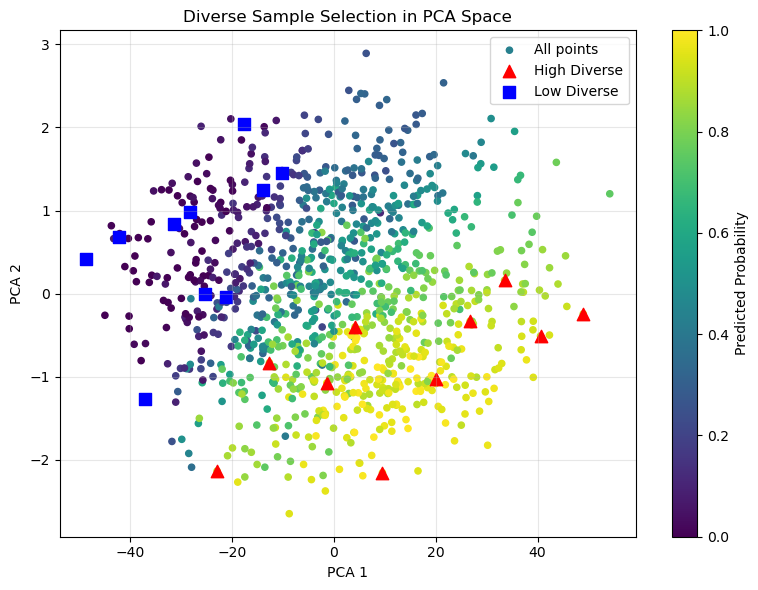

In [14]:
high_samples1, low_samples1, high_idxs1, low_idxs1 = run_diverse_selection_workflow(
    X=x_smi_similar1,
    y_pred=y_pred1,
    model=model_clf,
    df_reference=df_new1,
    n_select=10
)


Explained variance ratio (first 2 components): [0.99422984 0.00243676]


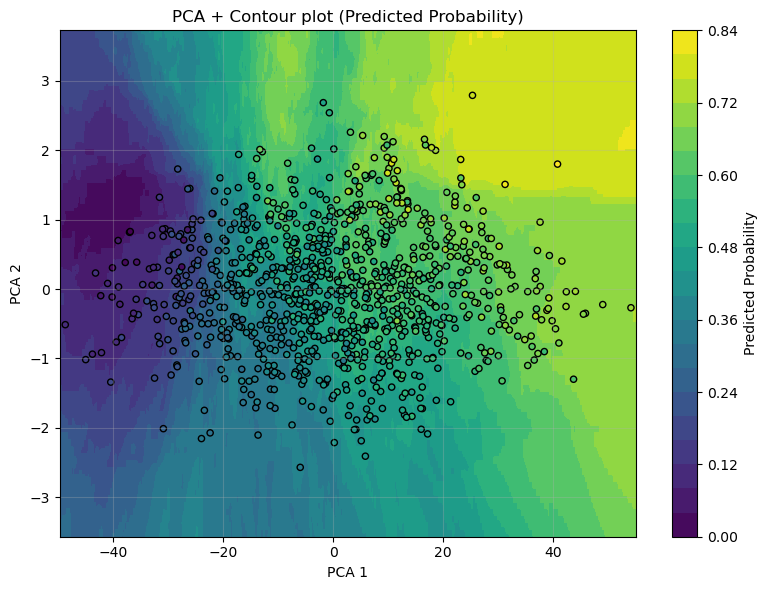

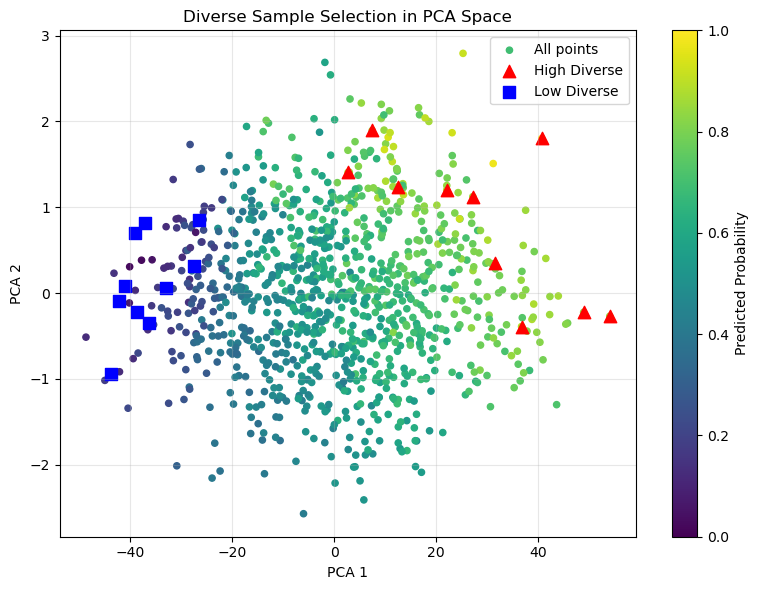

In [17]:
high_samples2, low_samples2, high_idxs2, low_idxs2 = run_diverse_selection_workflow(
    X=x_smi_similar2,
    y_pred=y_pred2,
    model=model_clf,
    df_reference=df_new2,
    n_select=10, threshold_high=0.7, threshold_low=0.1
)

Explained variance ratio (first 2 components): [0.99292303 0.00268165]


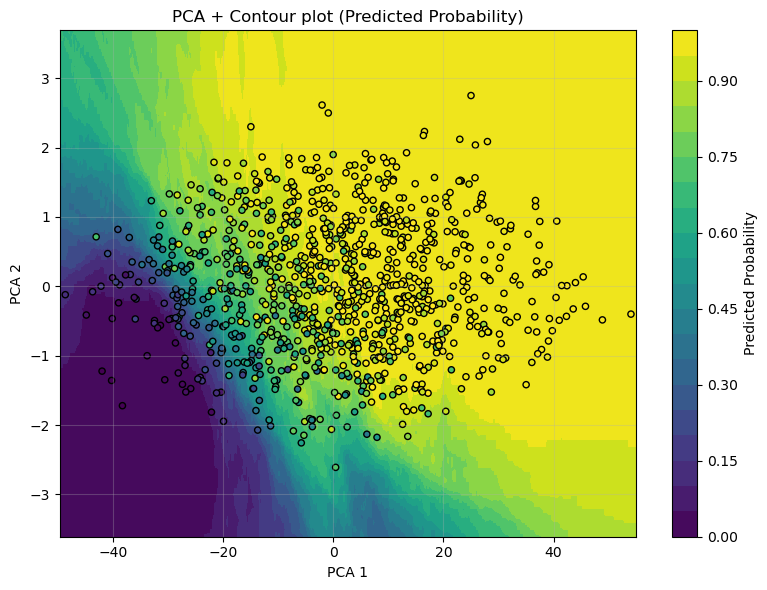

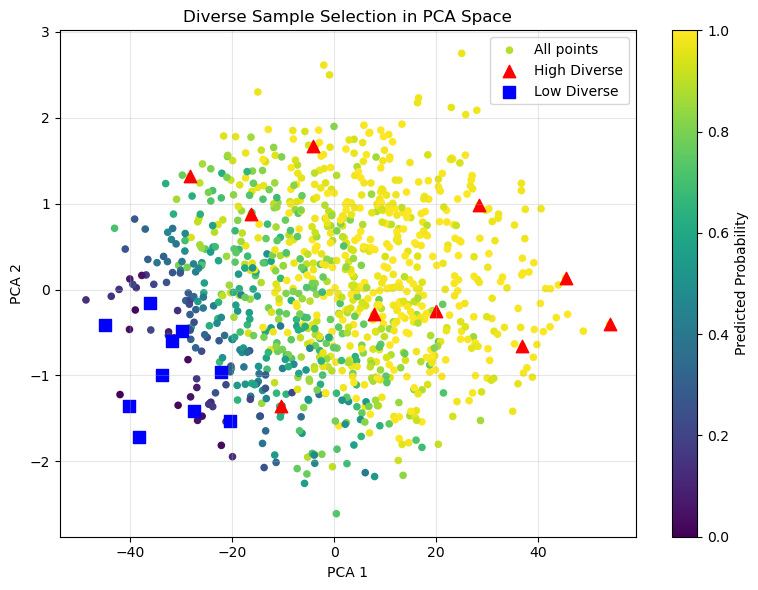

In [20]:
high_samples3, low_samples3, high_idxs3, low_idxs3 = run_diverse_selection_workflow(
    X=x_smi_similar3,
    y_pred=y_pred3,
    model=model_clf,
    df_reference=df_new3,
    n_select=10, 
)

Explained variance ratio (first 2 components): [0.98903235 0.00705207]


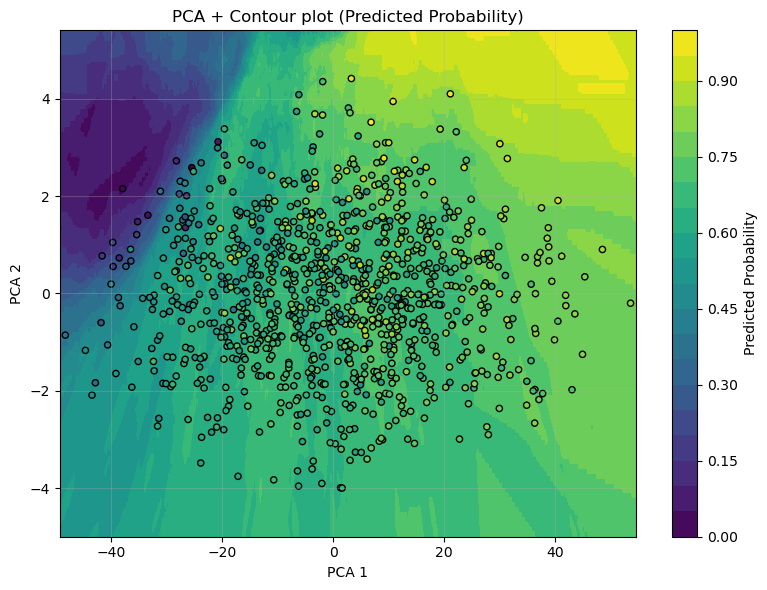

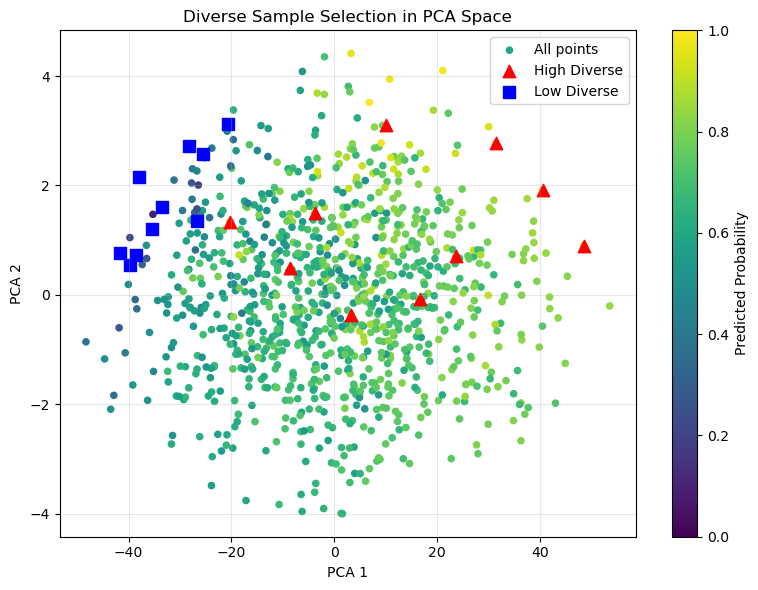

In [32]:
high_samples4, low_samples4, high_idxs4, low_idxs4 = run_diverse_selection_workflow(
    X=x_smi_similar4,
    y_pred=y_pred4,
    model=model_clf,
    df_reference=df_new4,
    n_select=10, threshold_high=0.8, threshold_low=0.3
)

In [33]:
low_samples4.shape

(10, 15)

In [36]:
# store all sampeles

In [37]:
all_samples_list = [high_samples0, low_samples0, high_samples1, low_samples1, high_samples2, low_samples2, high_samples3, low_samples3,
                   high_samples4, low_samples4] # Or a dictionary if you want names

output_file = "selected_samples_20250603.pkl"

with open(output_file, 'wb') as f:
    pickle.dump(all_samples_list, f) # Or pickle.dump(all_samples_dict, f)

print(f"All DataFrames pickled to '{output_file}'.")

# To load them back:
# with open(output_file, 'rb') as f:
#     loaded_list = pickle.load(f)

# loaded_high_samples0 = loaded_list[0]
# loaded_low_samples0 = loaded_list[1]

All DataFrames pickled to 'selected_samples_20250603.pkl'.


In [2]:
import pickle
# To load them back:
output_file = "selected_samples_20250603.pkl"

with open(output_file, 'rb') as f:
    loaded_list = pickle.load(f)

loaded_high_samples0 = loaded_list[4]
loaded_low_samples0 = loaded_list[5]

In [3]:
loaded_high_samples0

,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
7,CC(=CCC/C(=C/CO)/C)C,0.331215,CCCCCCCCCC(=O)[O-],1.737262,CCCCCCCCOC(=O)CN.Cl,1.388852,CCCC/C=C\CCCCCCCC(=O)O,1.683356,CCCCCCCCCCCCCCCC(=O)O,1.603315,CCCCCCCCCC=O,0.547850,CCCCCCCCCC(=O)OCC(CO)O,0.638995,1
845,CC(=CCC/C(=C/CO)/C)C,0.150889,CCCCCCCCCC(=O)[O-],1.764123,CCCCCCCCOC(=O)CN.Cl,1.194042,CCCC/C=C\CCCCCCCC(=O)O,0.511375,CCCCCCCCCCCCCCCC(=O)O,1.049628,CCCCCCCCCC=O,0.100318,CCCCCCCCCC(=O)OCC(CO)O,0.669467,1
71,CC(=CCC/C(=C/CO)/C)C,0.139282,CCCCCCCCCC(=O)[O-],1.745881,CCCCCCCCOC(=O)CN.Cl,1.767052,CCCC/C=C\CCCCCCCC(=O)O,1.250938,CCCCCCCCCCCCCCCC(=O)O,0.960556,CCCCCCCCCC=O,0.283617,CCCCCCCCCC(=O)OCC(CO)O,0.564080,1
400,CC(=CCC/C(=C/CO)/C)C,1.420140,CCCCCCCCCC(=O)[O-],1.626736,CCCCCCCCOC(=O)CN.Cl,1.690886,CCCC/C=C\CCCCCCCC(=O)O,1.720332,CCCCCCCCCCCCCCCC(=O)O,0.934330,CCCCCCCCCC=O,0.895498,CCCCCCCCCC(=O)OCC(CO)O,0.524927,1
963,CC(=CCC/C(=C/CO)/C)C,0.202905,CCCCCCCCCC(=O)[O-],1.021638,CCCCCCCCOC(=O)CN.Cl,1.544217,CCCC/C=C\CCCCCCCC(=O)O,0.854866,CCCCCCCCCCCCCCCC(=O)O,1.782020,CCCCCCCCCC=O,0.622319,CCCCCCCCCC(=O)OCC(CO)O,0.051345,1
388,CC(=CCC/C(=C/CO)/C)C,1.158299,CCCCCCCCCC(=O)[O-],1.745522,CCCCCCCCOC(=O)CN.Cl,1.517729,CCCC/C=C\CCCCCCCC(=O)O,0.042277,CCCCCCCCCCCCCCCC(=O)O,1.610004,CCCCCCCCCC=O,0.717637,CCCCCCCCCC(=O)OCC(CO)O,0.540916,1
146,CC(=CCC/C(=C/CO)/C)C,1.656296,CCCCCCCCCC(=O)[O-],1.739903,CCCCCCCCOC(=O)CN.Cl,1.691898,CCCC/C=C\CCCCCCCC(=O)O,0.849678,CCCCCCCCCCCCCCCC(=O)O,1.544573,CCCCCCCCCC=O,0.773853,CCCCCCCCCC(=O)OCC(CO)O,0.221184,1
769,CC(=CCC/C(=C/CO)/C)C,0.016282,CCCCCCCCCC(=O)[O-],1.161593,CCCCCCCCOC(=O)CN.Cl,0.915757,CCCC/C=C\CCCCCCCC(=O)O,0.798261,CCCCCCCCCCCCCCCC(=O)O,1.732575,CCCCCCCCCC=O,0.523385,CCCCCCCCCC(=O)OCC(CO)O,0.598485,1
447,CC(=CCC/C(=C/CO)/C)C,1.502376,CCCCCCCCCC(=O)[O-],1.442528,CCCCCCCCOC(=O)CN.Cl,1.474589,CCCC/C=C\CCCCCCCC(=O)O,1.671193,CCCCCCCCCCCCCCCC(=O)O,0.975172,CCCCCCCCCC=O,0.183517,CCCCCCCCCC(=O)OCC(CO)O,0.427522,1
303,CC(=CCC/C(=C/CO)/C)C,0.905209,CCCCCCCCCC(=O)[O-],1.732858,CCCCCCCCOC(=O)CN.Cl,0.748527,CCCC/C=C\CCCCCCCC(=O)O,1.763289,CCCCCCCCCCCCCCCC(=O)O,1.196752,CCCCCCCCCC=O,0.581543,CCCCCCCCCC(=O)OCC(CO)O,0.115031,1


In [39]:
df_info

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,ID,Name,Molecular_Formula,InChI,SMILES
0,A1,Decanal,C10H20O,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-9-10-11/h10H...,CCCCCCCCCC=O
1,A2,Geraniol,C10H18O,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",CC(=CCC/C(=C/CO)/C)C
2,A3,Hexadecanoic acid,C16H32O2,InChI=1S/C16H32O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCCCCCCCCCCCCCC(=O)O
3,A4,Myristoleic acid,C14H26O2,InChI=1S/C14H26O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCC/C=C\CCCCCCCC(=O)O
4,A5,Glycine octylester,C10H22ClNO2,InChI=1S/C10H21NO2.ClH/c1-2-3-4-5-6-7-8-13-10(...,CCCCCCCCOC(=O)CN.Cl
5,A6,Perfluorooctanoic acid,C8HF15O2,"InChI=1S/C8HF15O2/c9-2(10,1(24)25)3(11,12)4(13...",C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F...
6,A7,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",C8H5F13O3S,"InChI=1S/C8H5F13O3S/c9-3(10,1-2-25(22,23)24)4(...",C(CS(=O)(=O)O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)...
7,A8,Heptadecafluorooctanesulfonic acid potassium salt,C8F17KO3S,"InChI=1S/C8HF17O3S.K/c9-1(10,3(13,14)5(17,18)7...",C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...


In [47]:
import pandas as pd

# 1. Original component names for smi1–smi7
original_names = [
    'Decanoic acid', 'Decanoate', 'Decylamine',
    'Decyltrimethyl ammonium bromid', 'Decyl sodium sulfate',
    'Decanol', 'Glycerol monodecanoate'
]

# 2. Get mapping from column index to new molecule (if replaced)
replacement_mapping = {}
for i in range(1, 8):
    smi_col = f'smi{i}'
    unique_smis = high_samples2[smi_col].unique()
    for smile in unique_smis:
        matched = df_info[df_info['SMILES'] == smile]
        if not matched.empty:
            replacement_mapping[i] = matched.iloc[0]['Name']
            break

# 3. Create column renaming dictionary using either replacement or original names
column_rename_dict = {}
for i, original_name in enumerate(original_names, start=1):
    final_name = replacement_mapping.get(i, original_name)
    column_rename_dict[f'smi{i}'] = final_name
    column_rename_dict[f'conc{i}'] = final_name

# 4. Apply renaming to high_samples2
high_samples2_renamed = high_samples2.rename(columns=column_rename_dict)

# 5. (Optional) Print the renaming for verification
print("Renaming applied:")
for i in range(1, 8):
    smi_old = f'smi{i}'
    conc_old = f'conc{i}'
    final_name = column_rename_dict[smi_old]
    print(f"{smi_old}, {conc_old} → {final_name}")


Renaming applied:
smi1, conc1 → Geraniol
smi2, conc2 → Decanoate
smi3, conc3 → Glycine octylester
smi4, conc4 → Myristoleic acid
smi5, conc5 → Hexadecanoic acid
smi6, conc6 → Decanal
smi7, conc7 → Glycerol monodecanoate


In [48]:
high_samples2_renamed

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Geraniol,Geraniol,Decanoate,Decanoate,Glycine octylester,Glycine octylester,Myristoleic acid,Myristoleic acid,Hexadecanoic acid,Hexadecanoic acid,Decanal,Decanal,Glycerol monodecanoate,Glycerol monodecanoate,vesicles_formation
7,CC(=CCC/C(=C/CO)/C)C,0.331215,CCCCCCCCCC(=O)[O-],1.737262,CCCCCCCCOC(=O)CN.Cl,1.388852,CCCC/C=C\CCCCCCCC(=O)O,1.683356,CCCCCCCCCCCCCCCC(=O)O,1.603315,CCCCCCCCCC=O,0.547850,CCCCCCCCCC(=O)OCC(CO)O,0.638995,1
845,CC(=CCC/C(=C/CO)/C)C,0.150889,CCCCCCCCCC(=O)[O-],1.764123,CCCCCCCCOC(=O)CN.Cl,1.194042,CCCC/C=C\CCCCCCCC(=O)O,0.511375,CCCCCCCCCCCCCCCC(=O)O,1.049628,CCCCCCCCCC=O,0.100318,CCCCCCCCCC(=O)OCC(CO)O,0.669467,1
71,CC(=CCC/C(=C/CO)/C)C,0.139282,CCCCCCCCCC(=O)[O-],1.745881,CCCCCCCCOC(=O)CN.Cl,1.767052,CCCC/C=C\CCCCCCCC(=O)O,1.250938,CCCCCCCCCCCCCCCC(=O)O,0.960556,CCCCCCCCCC=O,0.283617,CCCCCCCCCC(=O)OCC(CO)O,0.564080,1
400,CC(=CCC/C(=C/CO)/C)C,1.420140,CCCCCCCCCC(=O)[O-],1.626736,CCCCCCCCOC(=O)CN.Cl,1.690886,CCCC/C=C\CCCCCCCC(=O)O,1.720332,CCCCCCCCCCCCCCCC(=O)O,0.934330,CCCCCCCCCC=O,0.895498,CCCCCCCCCC(=O)OCC(CO)O,0.524927,1
963,CC(=CCC/C(=C/CO)/C)C,0.202905,CCCCCCCCCC(=O)[O-],1.021638,CCCCCCCCOC(=O)CN.Cl,1.544217,CCCC/C=C\CCCCCCCC(=O)O,0.854866,CCCCCCCCCCCCCCCC(=O)O,1.782020,CCCCCCCCCC=O,0.622319,CCCCCCCCCC(=O)OCC(CO)O,0.051345,1
388,CC(=CCC/C(=C/CO)/C)C,1.158299,CCCCCCCCCC(=O)[O-],1.745522,CCCCCCCCOC(=O)CN.Cl,1.517729,CCCC/C=C\CCCCCCCC(=O)O,0.042277,CCCCCCCCCCCCCCCC(=O)O,1.610004,CCCCCCCCCC=O,0.717637,CCCCCCCCCC(=O)OCC(CO)O,0.540916,1
146,CC(=CCC/C(=C/CO)/C)C,1.656296,CCCCCCCCCC(=O)[O-],1.739903,CCCCCCCCOC(=O)CN.Cl,1.691898,CCCC/C=C\CCCCCCCC(=O)O,0.849678,CCCCCCCCCCCCCCCC(=O)O,1.544573,CCCCCCCCCC=O,0.773853,CCCCCCCCCC(=O)OCC(CO)O,0.221184,1
769,CC(=CCC/C(=C/CO)/C)C,0.016282,CCCCCCCCCC(=O)[O-],1.161593,CCCCCCCCOC(=O)CN.Cl,0.915757,CCCC/C=C\CCCCCCCC(=O)O,0.798261,CCCCCCCCCCCCCCCC(=O)O,1.732575,CCCCCCCCCC=O,0.523385,CCCCCCCCCC(=O)OCC(CO)O,0.598485,1
447,CC(=CCC/C(=C/CO)/C)C,1.502376,CCCCCCCCCC(=O)[O-],1.442528,CCCCCCCCOC(=O)CN.Cl,1.474589,CCCC/C=C\CCCCCCCC(=O)O,1.671193,CCCCCCCCCCCCCCCC(=O)O,0.975172,CCCCCCCCCC=O,0.183517,CCCCCCCCCC(=O)OCC(CO)O,0.427522,1
303,CC(=CCC/C(=C/CO)/C)C,0.905209,CCCCCCCCCC(=O)[O-],1.732858,CCCCCCCCOC(=O)CN.Cl,0.748527,CCCC/C=C\CCCCCCCC(=O)O,1.763289,CCCCCCCCCCCCCCCC(=O)O,1.196752,CCCCCCCCCC=O,0.581543,CCCCCCCCCC(=O)OCC(CO)O,0.115031,1


In [53]:
# Keep only every second column starting from index 1 (i.e., concentration columns)
high_conc_only = high_samples2_renamed.iloc[:, 1::2].copy()

# Apply inverse log1p to get back the original concentrations
import numpy as np
high_conc_original = high_conc_only.apply(np.expm1)

high_conc_original.head()

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Geraniol,Decanoate,Glycine octylester,Myristoleic acid,Hexadecanoic acid,Decanal,Glycerol monodecanoate
7,0.392659,4.681768,3.010242,4.383594,3.969481,0.729531,0.894575
845,0.162868,4.836453,2.300393,0.667583,1.856588,0.105522,0.953196
71,0.149448,4.730949,4.853574,2.493618,1.613148,0.327925,0.757829
400,3.137699,4.087244,4.424286,4.586383,1.545508,1.448555,0.690336
963,0.224956,1.777742,3.684302,1.351059,4.941847,0.863243,0.052686


In [54]:
high_samples2

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
7,CC(=CCC/C(=C/CO)/C)C,0.331215,CCCCCCCCCC(=O)[O-],1.737262,CCCCCCCCOC(=O)CN.Cl,1.388852,CCCC/C=C\CCCCCCCC(=O)O,1.683356,CCCCCCCCCCCCCCCC(=O)O,1.603315,CCCCCCCCCC=O,0.547850,CCCCCCCCCC(=O)OCC(CO)O,0.638995,1
845,CC(=CCC/C(=C/CO)/C)C,0.150889,CCCCCCCCCC(=O)[O-],1.764123,CCCCCCCCOC(=O)CN.Cl,1.194042,CCCC/C=C\CCCCCCCC(=O)O,0.511375,CCCCCCCCCCCCCCCC(=O)O,1.049628,CCCCCCCCCC=O,0.100318,CCCCCCCCCC(=O)OCC(CO)O,0.669467,1
71,CC(=CCC/C(=C/CO)/C)C,0.139282,CCCCCCCCCC(=O)[O-],1.745881,CCCCCCCCOC(=O)CN.Cl,1.767052,CCCC/C=C\CCCCCCCC(=O)O,1.250938,CCCCCCCCCCCCCCCC(=O)O,0.960556,CCCCCCCCCC=O,0.283617,CCCCCCCCCC(=O)OCC(CO)O,0.564080,1
400,CC(=CCC/C(=C/CO)/C)C,1.420140,CCCCCCCCCC(=O)[O-],1.626736,CCCCCCCCOC(=O)CN.Cl,1.690886,CCCC/C=C\CCCCCCCC(=O)O,1.720332,CCCCCCCCCCCCCCCC(=O)O,0.934330,CCCCCCCCCC=O,0.895498,CCCCCCCCCC(=O)OCC(CO)O,0.524927,1
963,CC(=CCC/C(=C/CO)/C)C,0.202905,CCCCCCCCCC(=O)[O-],1.021638,CCCCCCCCOC(=O)CN.Cl,1.544217,CCCC/C=C\CCCCCCCC(=O)O,0.854866,CCCCCCCCCCCCCCCC(=O)O,1.782020,CCCCCCCCCC=O,0.622319,CCCCCCCCCC(=O)OCC(CO)O,0.051345,1
388,CC(=CCC/C(=C/CO)/C)C,1.158299,CCCCCCCCCC(=O)[O-],1.745522,CCCCCCCCOC(=O)CN.Cl,1.517729,CCCC/C=C\CCCCCCCC(=O)O,0.042277,CCCCCCCCCCCCCCCC(=O)O,1.610004,CCCCCCCCCC=O,0.717637,CCCCCCCCCC(=O)OCC(CO)O,0.540916,1
146,CC(=CCC/C(=C/CO)/C)C,1.656296,CCCCCCCCCC(=O)[O-],1.739903,CCCCCCCCOC(=O)CN.Cl,1.691898,CCCC/C=C\CCCCCCCC(=O)O,0.849678,CCCCCCCCCCCCCCCC(=O)O,1.544573,CCCCCCCCCC=O,0.773853,CCCCCCCCCC(=O)OCC(CO)O,0.221184,1
769,CC(=CCC/C(=C/CO)/C)C,0.016282,CCCCCCCCCC(=O)[O-],1.161593,CCCCCCCCOC(=O)CN.Cl,0.915757,CCCC/C=C\CCCCCCCC(=O)O,0.798261,CCCCCCCCCCCCCCCC(=O)O,1.732575,CCCCCCCCCC=O,0.523385,CCCCCCCCCC(=O)OCC(CO)O,0.598485,1
447,CC(=CCC/C(=C/CO)/C)C,1.502376,CCCCCCCCCC(=O)[O-],1.442528,CCCCCCCCOC(=O)CN.Cl,1.474589,CCCC/C=C\CCCCCCCC(=O)O,1.671193,CCCCCCCCCCCCCCCC(=O)O,0.975172,CCCCCCCCCC=O,0.183517,CCCCCCCCCC(=O)OCC(CO)O,0.427522,1
303,CC(=CCC/C(=C/CO)/C)C,0.905209,CCCCCCCCCC(=O)[O-],1.732858,CCCCCCCCOC(=O)CN.Cl,0.748527,CCCC/C=C\CCCCCCCC(=O)O,1.763289,CCCCCCCCCCCCCCCC(=O)O,1.196752,CCCCCCCCCC=O,0.581543,CCCCCCCCCC(=O)OCC(CO)O,0.115031,1


In [57]:
import joblib

In [58]:
def save_objects_joblib(filepath, **kwargs):
    """
    Save multiple Python objects using joblib.

    Parameters:
    - filepath: str — path to save the .pkl file.
    - **kwargs: any number of named Python objects to save.
    """
    joblib.dump(kwargs, filepath)

In [62]:
save_objects_joblib(
    "results_generate_experimental_plan1_20250606.pkl",
    model_clf=model_clf,
    x_smi_ori=x_smi_ori,
    y_pred_ori=y_pred_ori,
    x_smi_similar1=x_smi_similar1,
    y_pred1=y_pred1,
    x_smi_similar2=x_smi_similar2,
    y_pred2=y_pred2,
    x_smi_similar3=x_smi_similar3,
    y_pred3=y_pred3,
    x_smi_similar4=x_smi_similar4,
    y_pred4=y_pred4,
    df_new1=df_new1,
    df_new2=df_new2,
    df_new3=df_new3,
    df_new4=df_new4,
)

In [2]:
from joblib import load

data = load("results_generate_experimental_plan1_20250606.pkl")


In [5]:
x_smi_similar2 = data["x_smi_similar2"]
x_smi_similar2

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.666057,-2.332763,0.488793,2.187598,2.533271,-3.617496,6.434544,0.494519,4.462606,1.289628,...,-6.792001,-1.082216,1.408377,1.518100,-2.809555,2.801323,-3.145283,4.753322,3.051321,-0.259718
1,2.125181,-3.043523,0.578494,2.689343,3.166258,-4.618097,8.135294,0.572658,5.534494,1.636758,...,-8.488196,-1.252359,1.779703,1.898693,-3.629258,3.496658,-4.064246,6.010746,3.886972,-0.437349
2,1.128911,-1.627107,0.355982,1.470952,1.672018,-2.498262,4.471586,0.348076,3.039224,0.916036,...,-4.592660,-0.745278,0.972219,1.050436,-1.969985,1.960845,-2.210476,3.280630,2.125415,-0.223891
3,1.247438,-1.887121,0.428142,1.679353,1.965971,-2.872334,5.207999,0.406283,3.554936,1.083427,...,-5.279414,-0.857859,1.100596,1.251678,-2.274242,2.298932,-2.560813,3.821796,2.465822,-0.221389
4,1.489741,-1.921858,0.350368,1.770539,1.956240,-2.996366,5.188503,0.366840,3.481059,1.012784,...,-5.586702,-0.801112,1.222341,1.188243,-2.363699,2.227536,-2.578182,3.806373,2.511064,-0.410316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.521008,-2.230224,0.511531,2.057154,2.388039,-3.461149,6.207709,0.486588,4.279950,1.276130,...,-6.384150,-1.063214,1.325590,1.446862,-2.662070,2.709478,-3.023157,4.587925,2.936109,-0.155718
996,1.575741,-2.299587,0.531576,2.115113,2.420034,-3.610230,6.542829,0.504031,4.447187,1.368676,...,-6.671868,-1.060869,1.410967,1.528406,-2.865687,2.869140,-3.159389,4.837368,3.105007,-0.268894
997,1.636179,-2.422708,0.557508,2.220380,2.490473,-3.784476,6.905879,0.547203,4.685556,1.461523,...,-6.938093,-1.140797,1.462722,1.595398,-3.064971,3.037170,-3.374827,5.115787,3.255525,-0.330510
998,1.224792,-1.884413,0.384560,1.610654,1.954221,-2.811095,4.990633,0.356726,3.403955,1.024163,...,-5.073008,-0.786287,1.045230,1.170840,-2.174523,2.150706,-2.504406,3.686189,2.371576,-0.167486


In [7]:
y_pred2 = data["y_pred2"]
y_pred2.max()

0.83

In [10]:
import numpy as np
top10_values = np.sort(y_pred2)[-10:][::-1]
top10_values

array([0.83, 0.81, 0.78, 0.77, 0.77, 0.76, 0.76, 0.75, 0.75, 0.75])

In [3]:
model_clf = data["model_clf"]
x_smi_ori = data["x_smi_ori"]
y_pred_ori = data["y_pred_ori"]
x_smi_similar1 = data["x_smi_similar1"]
y_pred1 = data["y_pred1"]
x_smi_similar2 = data["x_smi_similar2"]
y_pred2 = data["y_pred2"]
x_smi_similar3 = data["x_smi_similar3"]
y_pred3 = data["y_pred3"]
x_smi_similar4 = data["x_smi_similar4"]
y_pred4 = data["y_pred4"]
df_new1 = data["df_new1"]
df_new2 = data["df_new2"]
df_new3 = data["df_new3"]
df_new4 = data["df_new4"]


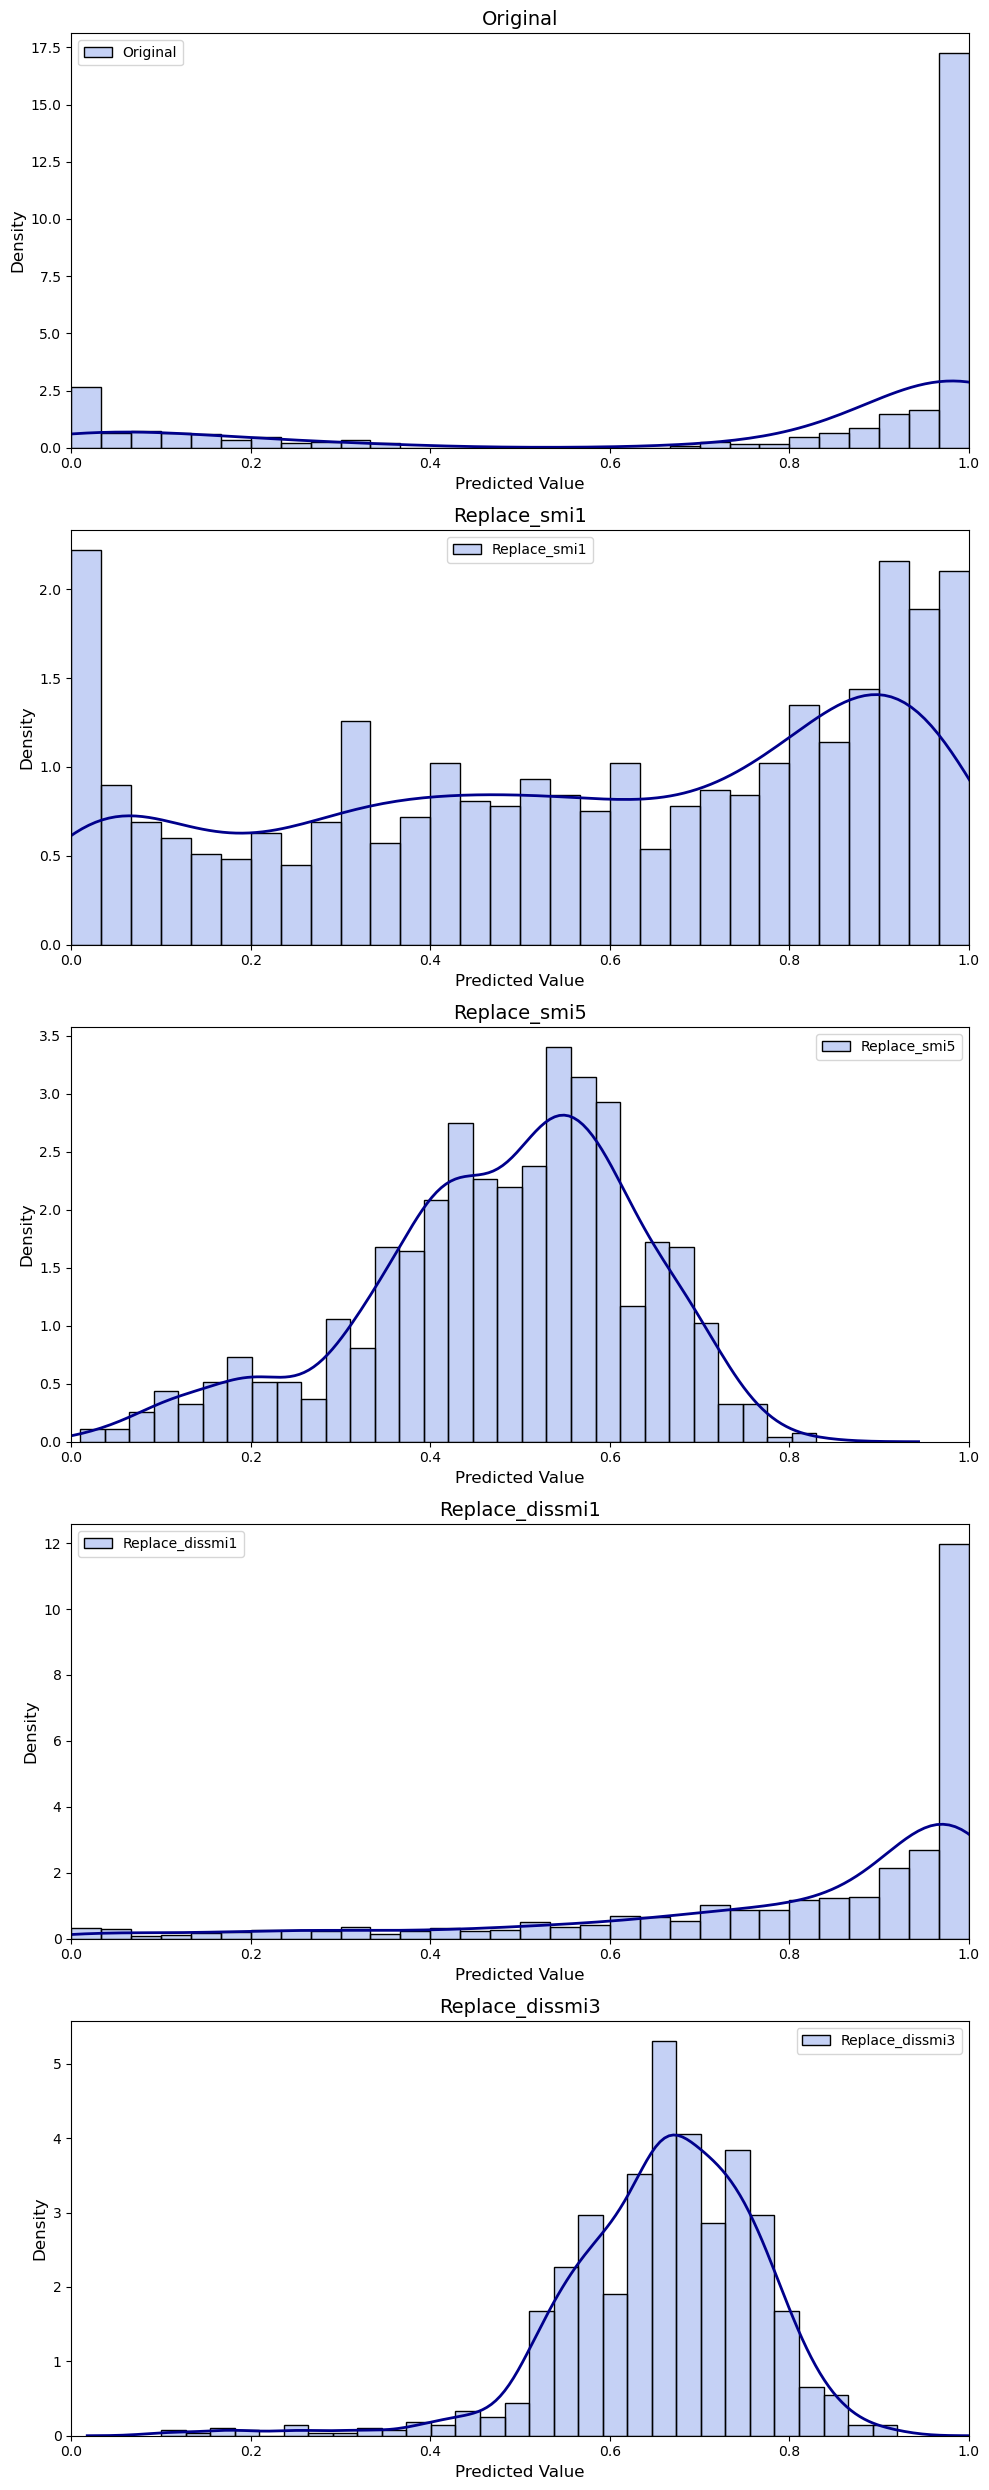

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group all predictions into a dictionary
y_sets = {
    'Original': y_pred_ori,
    'Replace_smi1': y_pred1,
    'Replace_smi5': y_pred2,
    'Replace_dissmi1': y_pred3,
    'Replace_dissmi3': y_pred4,
}

# Create 5 subplots, one for each set
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

# Plot each set in its own axis
for ax, (label, y) in zip(axs, y_sets.items()):
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, ax=ax, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2, ax=ax)
    ax.set_title(label, fontsize=14)
    ax.set_xlabel("Predicted Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlim(0, 1)  # Fix x-axis range
    ax.legend()

plt.tight_layout()
plt.show()


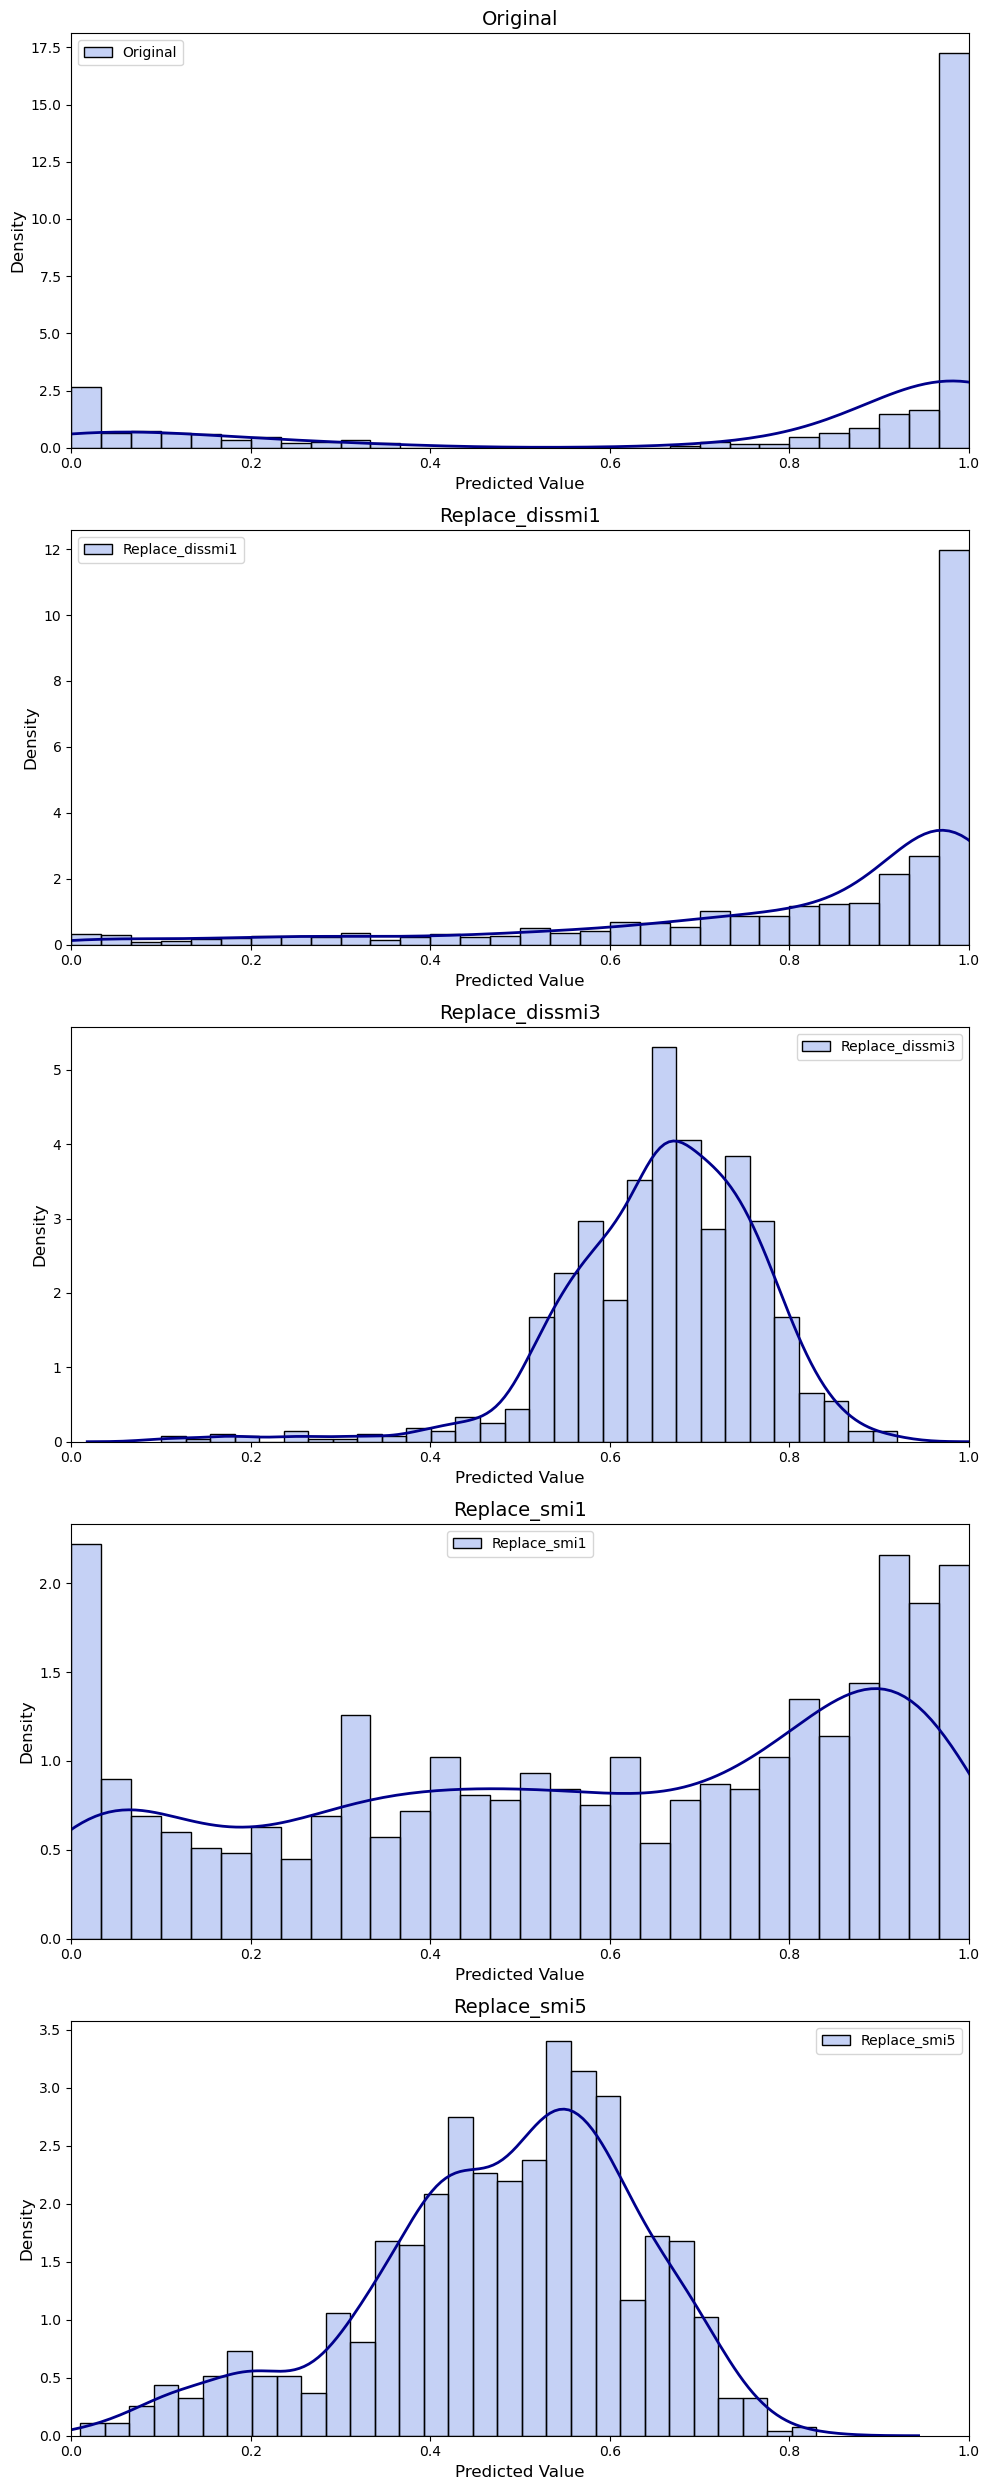

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group all predictions into a dictionary
y_sets = {
    'Original': y_pred_ori,
    
    'Replace_dissmi1': y_pred3,
    'Replace_dissmi3': y_pred4,
    'Replace_smi1': y_pred1,
    'Replace_smi5': y_pred2,
}

# Create 5 subplots, one for each set
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

# Plot each set in its own axis
for ax, (label, y) in zip(axs, y_sets.items()):
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, ax=ax, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2, ax=ax)
    ax.set_title(label, fontsize=14)
    ax.set_xlabel("Predicted Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlim(0, 1)  # Fix x-axis range
    ax.legend()

plt.tight_layout()
plt.show()


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

y_sets = {
    'Original': y_pred_ori,
    'Replace_dissmi1': y_pred3,
    'Replace_dissmi3': y_pred4,
    'Replace_smi1': y_pred1,
    'Replace_smi5': y_pred2,
}

for label, y in y_sets.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2)
    # plt.title(label, fontsize=14)
    # plt.xlabel("Predicted Probabilities", fontsize=20)
    # plt.ylabel("Density", fontsize=20)
    plt.xlabel("Predicted Probabilities", fontsize=20, labelpad=15)
    plt.ylabel("Density", fontsize=20, labelpad=15)
    plt.tick_params(axis="both", which="major", labelsize=20, pad=8)  
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(0, 1)
    # plt.legend()
    plt.tight_layout()
    
    # Save each figure
    plt.savefig(f"../results/{label}_prob_1stround.png", dpi=500, bbox_inches="tight")
    plt.close()